### Практикум. Мультисенсорный подход для изучения  мезомасштабных и субмезомасштабных процессов в океане

**Цель практикума** - Научиться комбинировать данные с различных сенсоров и научиться интепретировать полученные результаты. 

<img src="attachment:ccfb1783-d452-476c-881e-e27455047e5f.webp" width="600">

Данные:

1. Файл **SST.nc**  содержит среднемесячные поля температуры поверхности моря (SST) в восточной части Тихого океана.

2. Файлы  **sst_ostia.nc** и **SST_peru.nc**  содержат  поля температуры поверхности моря (SST) у побережья Перу. Разница  - в пространственном разрешении и временном охвате данных. 

3. Файл **CHL_peru.nc** содержит ежедневные поля концентрации хлорофилла в поверхностном слое океана у побережья Перу. 

4. Файлы **SLA_gulfstream.nc** и **SST_gulfstream.nc** содержат данные по аномалиям уровня и температуру для района течения Гольфстрим.

5. Файл **SWOT.nc** содержит данные по аномалиям уровня c миссии SWOT для района течения Гольфстрим. 


Данные по концентрации хлорофилла получены из массива Global Ocean Colour Plankton MY L4 monthly observations (https://data.marine.copernicus.eu/product/OCEANCOLOUR_GLO_BGC_L4_MY_009_108/description)

Данные по температуре поверхности моря получены из двух массивов: Global Ocean Ensemble Physics Reanalysis (https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_ENS_001_031/description) и Global Ocean OSTIA Sea Surface Temperature and Sea Ice Analysis (https://data.marine.copernicus.eu/product/SST_GLO_SST_L4_NRT_OBSERVATIONS_010_001/description)

Данные SWOT можно скачать отсюда: aviso.altimetry.fr




In [452]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose, STL , MSTL
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset, num2date
from scipy.interpolate import RegularGridInterpolator
import scipy.stats as stats

**Задание 1**. Данное задание является дополнением к **Заданию 4** из **Практикума по альтиметрии**. 

 - Рассчитайте тренд SST и постройте его пространственное распределение для исследуемого региона (используйте код из задания по альтиметрии)
 - Сравните полученный результат с трендом SLA для исследуемого региона. Какие выводы можно сделать по результатам сопоставления двух типов данных? 
 

In [453]:
ds_sst = nc.Dataset('/Users/user/Yandex.Disk.localized/Лекции/ПУ/Школа/День_1/Альтиметрия/Задание 2/SST.nc','r')

In [454]:
sst = ds_sst.variables['thetao_cglo'][:]
longitude = ds_sst.variables['longitude'][:]
latitude = ds_sst.variables['latitude'][:]
time = ds_sst.variables['time']
sst = sst.squeeze()

In [455]:
#код для вычисление линейного тренда аномалий уровня моря:
#Определение размеров массива
nt, nlat, nlon = sst.shape
ngrd = nlon*nlat

# Преобразование данных в формат 2D
sst_grd  = sst.reshape((nt, ngrd), order='F') 

#Создание массива для хранения трендов
x = np.linspace(1,nt,nt)
sst_rate = np.empty((ngrd,1))
sst_rate[:,:] = np.nan

#Цикл по каждой точке сетки, рассчет линейной аппроксимация тренда
for i in range(ngrd): 
    y = sst_grd[:,i]         
    z = np.polyfit(x, y, 1)
    sst_rate[i,0] = z[0]*12

In [441]:
#Восстановление в 2D формат
sst_trend = sst_rate.reshape((nlat,nlon), order='F')

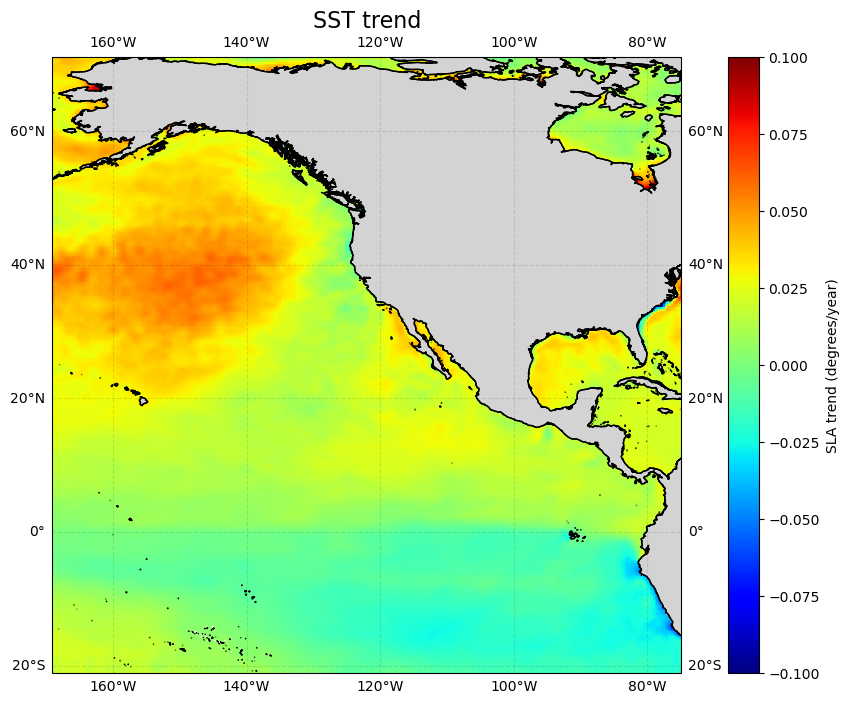

In [442]:
#Постройте пространственное распределение тренда для исследуемого региона
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m'),
               facecolor='lightgray', edgecolor='black')
ax.coastlines(resolution='50m', color='black')  # '50m' for moderate resolution
cmap = plt.cm.Spectral_r
cax2 = ax.pcolormesh(longitude, latitude, sst_trend,  vmin=-0.1, vmax=0.1,
                        cmap='jet',
                        transform=ccrs.PlateCarree())
gl0 = ax.gridlines(draw_labels=True, color='black', alpha=0.1, linestyle='--')
cbar = plt.colorbar(cax2, ax=ax, orientation='vertical', pad=0.05, label='SLA trend (degrees/year)')
plt.title('SST trend', fontsize=16)
plt.show()

Проанализируйте полученный результат.

**Задание 2**. Вам необходимо проанализировать характер распределения SST и поверхностной концентрации хлорофилла (CHL) у побережья Перу. 

 - Постройте распределения CHL и SST для региона исследования на дату 01.01.2015

 - Рассчитайте среднемесячные распределения CHL и SST для региона исследования. Постройте распределение для каждого месяца
 
 - Рассчитайте  пространственное распределение стандартного отклонения SST и CHL для исследумого региона и визуализируйте его 

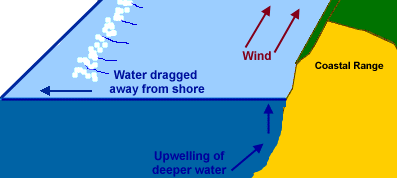

**Перуанский апвеллинг** — это природное явление, при котором глубинные холодные воды поднимаются к поверхности океана вдоль западного побережья Южной Америки (Перу и Чили). Это один из самых мощных и продуктивных апвеллингов в мире, играющий ключевую роль в формировании уникальной экосистемы и климата региона.

In [443]:
ch = nc.Dataset('/Users/user/Yandex.Disk.localized/Лекции/ПУ/Школа/День_1/Альтиметрия/Задание 2/CHL_peru.nc','r')
st = nc.Dataset('/Users/user/Yandex.Disk.localized/Лекции/ПУ/Школа/День_1/Альтиметрия/Задание 2/SST_peru.nc','r')
st_ost = nc.Dataset('/Users/user/Yandex.Disk.localized/Лекции/ПУ/Школа/День_1/Альтиметрия/Задание 2/sst_ostia.nc')

In [458]:
ch = nc.Dataset('/Users/user/Yandex.Disk.localized/Лекции/ПУ/Школа/День_1/Альтиметрия/Задание 2/CHL_peru.nc','r')
st = nc.Dataset('/Users/user/Yandex.Disk.localized/Лекции/ПУ/Школа/День_1/Альтиметрия/Задание 2/SST_peru.nc','r')
st_ost = nc.Dataset('/Users/user/Yandex.Disk.localized/Лекции/ПУ/Школа/День_1/Альтиметрия/Задание 2/sst_ostia.nc','r')

chl = ch.variables['CHL'][:]
chl_lons = ch.variables['longitude'][:]
chl_lats = ch.variables['latitude'][:]
chl_time = ch.variables['time']


sst_lons = st.variables['longitude'][:]
sst_lats = st.variables['latitude'][:]
sst = st.variables['thetao_cglo'][:]
sst = sst.squeeze()

ost_lons = st_ost.variables['longitude'][:]
ost_lats = st_ost.variables['latitude'][:]
ost = st_ost.variables['analysed_sst'][:]
ost = ost.squeeze()

In [459]:
# Конвертируем время
dates = num2date(chl_time[:], units=chl_time.units, calendar=chl_time.calendar)
formatted_dates = [dt.strftime("%d.%m.%Y") for dt in dates]
chl_time  = formatted_dates[:]
chl_time = np.array(chl_time)

Постройте распределения CHL и SST для региона исследования на дату 01.01.2015. Данные возьмите из файлов **sst_ostia.nc** и **CHL_peru.nc**. Для данных SST конвертируйт Кельвины в градусы цельсия. 

In [460]:
time_index = np.where(chl_time == '01.01.2015')[0][0]  # Find index of the matching date

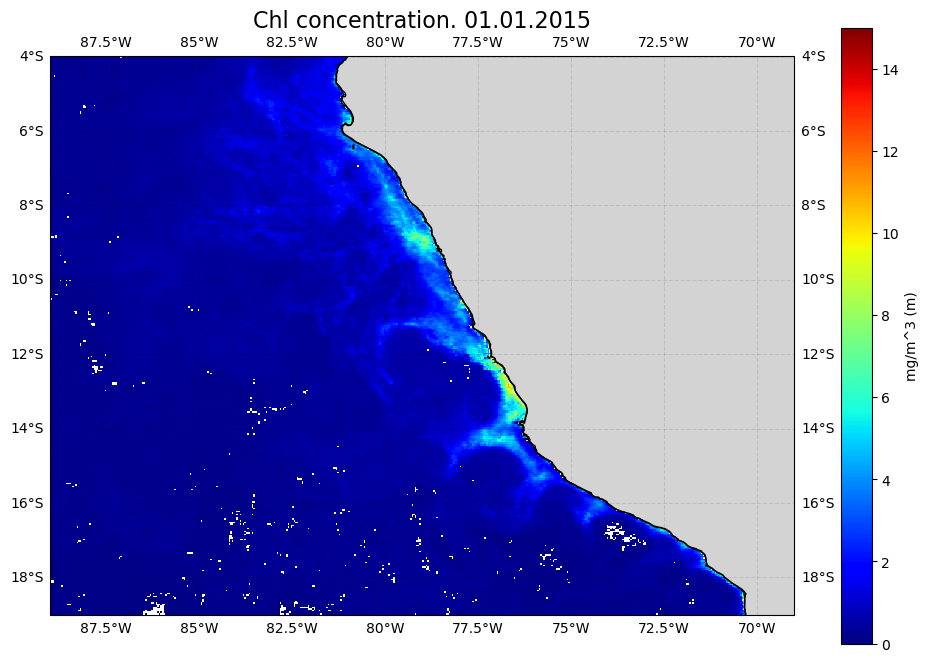

In [461]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m'),
               facecolor='lightgray', edgecolor='black')
ax.coastlines(resolution='50m', color='black')  # '50m' for moderate resolution
cax2 = ax.pcolormesh(chl_lons, chl_lats, chl[time_index,:,:],vmin=0, vmax=15,
                        cmap='jet',
                        transform=ccrs.PlateCarree())
gl0 = ax.gridlines(draw_labels=True, color='black', alpha=0.1, linestyle='--')
cbar = plt.colorbar(cax2, ax=ax, orientation='vertical', pad=0.05, label='mg/m^3 (m)')
plt.title('Chl concentration. 01.01.2015', fontsize=16)
plt.show()

In [462]:
# Конвертируйт Кельвины в градусы цельсия 
ost = ost-273.15

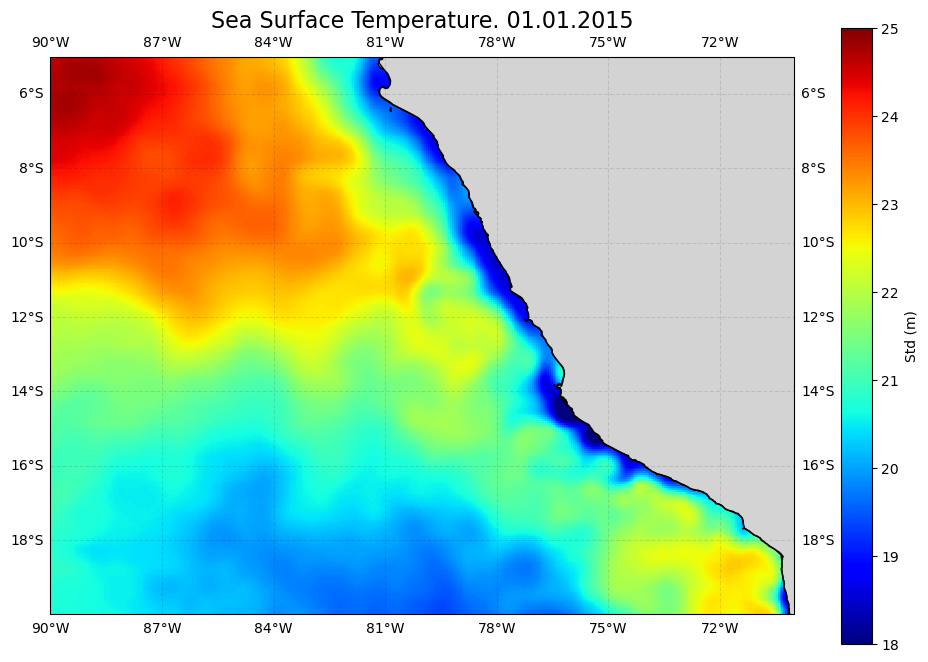

In [463]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m'),
               facecolor='lightgray', edgecolor='black')
ax.coastlines(resolution='50m', color='black')  # '50m' for moderate resolution
cax2 = ax.pcolormesh(ost_lons, ost_lats, ost, vmin=18, vmax=25,
                        cmap='jet',
                        transform=ccrs.PlateCarree())
gl0 = ax.gridlines(draw_labels=True, color='black', alpha=0.1, linestyle='--')
cbar = plt.colorbar(cax2, ax=ax, orientation='vertical', pad=0.05, label='Std (m)')
plt.title('Sea Surface Temperature. 01.01.2015', fontsize=16)
plt.show()

Сопоставьте полученную картину и проанализируйте разультат. Как данные по температуре и концентрации хлорофилла дополняют друг друга? 

Рассчитайте среднемесячные значения CHL.  Данные возьмите из файла **CHL_peru.nc**. Постройте среднемесячные поля CHL для каждого месяца. 

In [464]:
years = chl.shape[0] // 12  # Определяем число лет
chl_monthly_mean = chl.reshape(years, 12, *chl.shape[1:]).mean(axis=0)

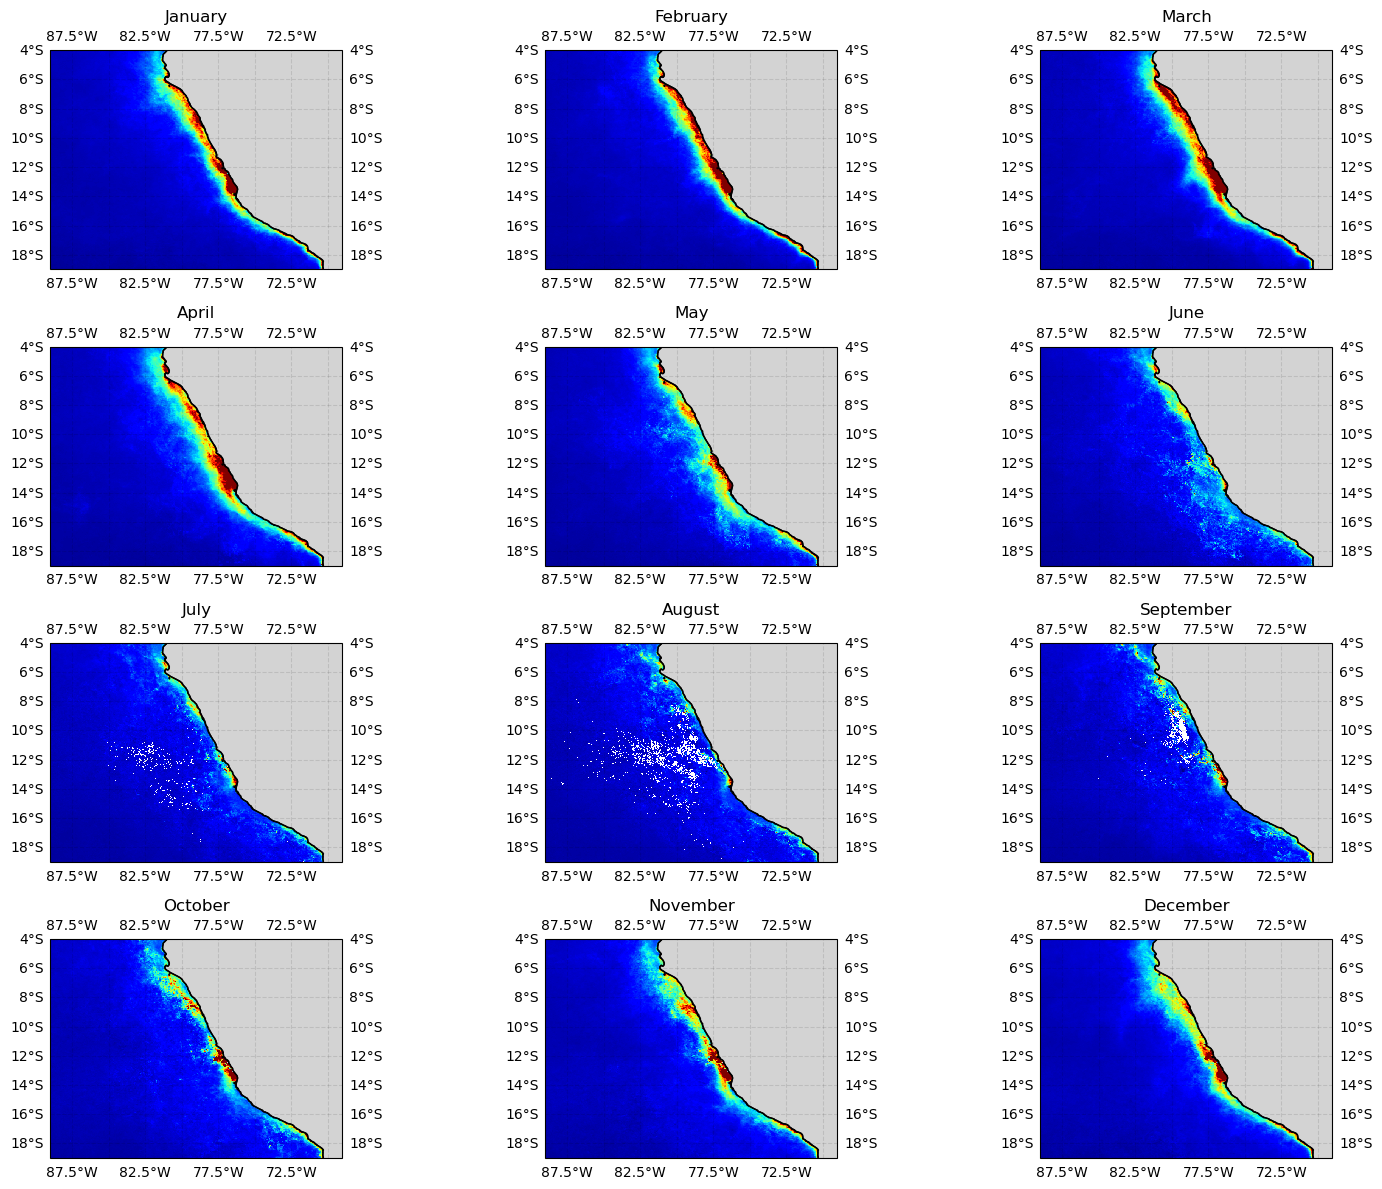

In [465]:

# Создание фигуры и сетки подграфиков (3 строки и 4 столбца)
fig, axs = plt.subplots(4, 3, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})

# Список месяцев
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Итерируем по месяцам и строим графики
for i in range(12):
    ax = axs[i // 3, i % 3] 
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m'),
                   facecolor='lightgray', edgecolor='black')
    ax.coastlines(resolution='50m', color='black')  # '50m' for moderate resolution
    
    # Отображаем данные для текущего месяца
    cax2 = ax.pcolormesh(chl_lons, chl_lats, chl_monthly_mean[i], vmin=0, vmax=5, cmap='jet', transform=ccrs.PlateCarree())
    
    ax.gridlines(draw_labels=True, color='black', alpha=0.1, linestyle='--')
    
    ax.set_title(months[i])
plt.tight_layout()

# Показать график
plt.show()


Рассчитайте и постройте пространственные распределения CHL и SST для региона исследования.  Данные возьмите из файлов **SST_peru.nc** и **CHL_peru.nc**.

In [466]:
sst_std = np.std(sst,axis=0)
chl_std = np.std(chl,axis=0)

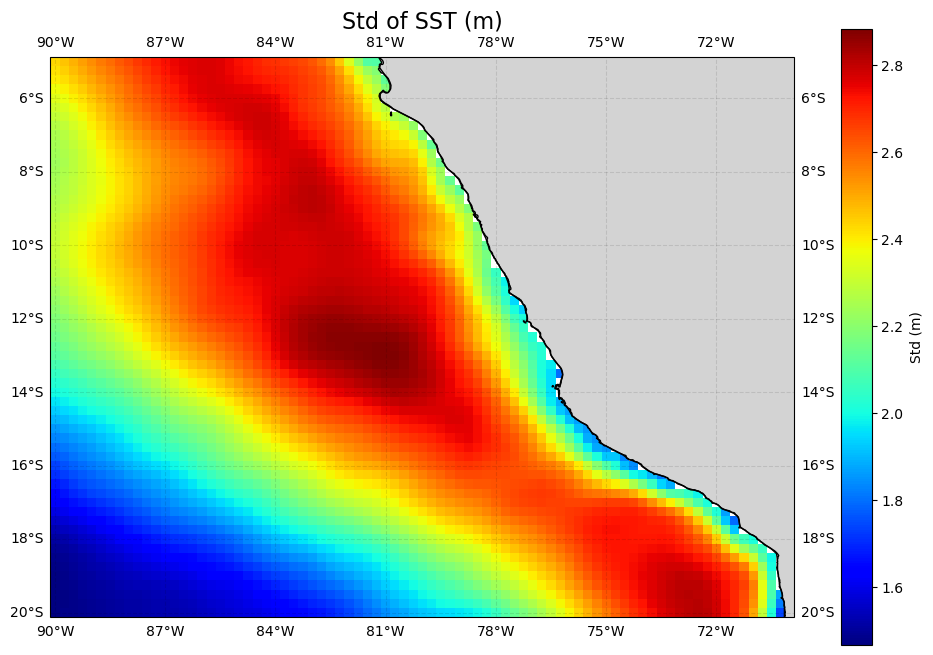

In [467]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m'),
               facecolor='lightgray', edgecolor='black')
ax.coastlines(resolution='50m', color='black')  # '50m' for moderate resolution
cax2 = ax.pcolormesh(sst_lons, sst_lats, sst_std,
                        cmap='jet',
                        transform=ccrs.PlateCarree())
gl0 = ax.gridlines(draw_labels=True, color='black', alpha=0.1, linestyle='--')
cbar = plt.colorbar(cax2, ax=ax, orientation='vertical', pad=0.05, label='Std (m)')
plt.title('Std of SST (m)', fontsize=16)
plt.show()

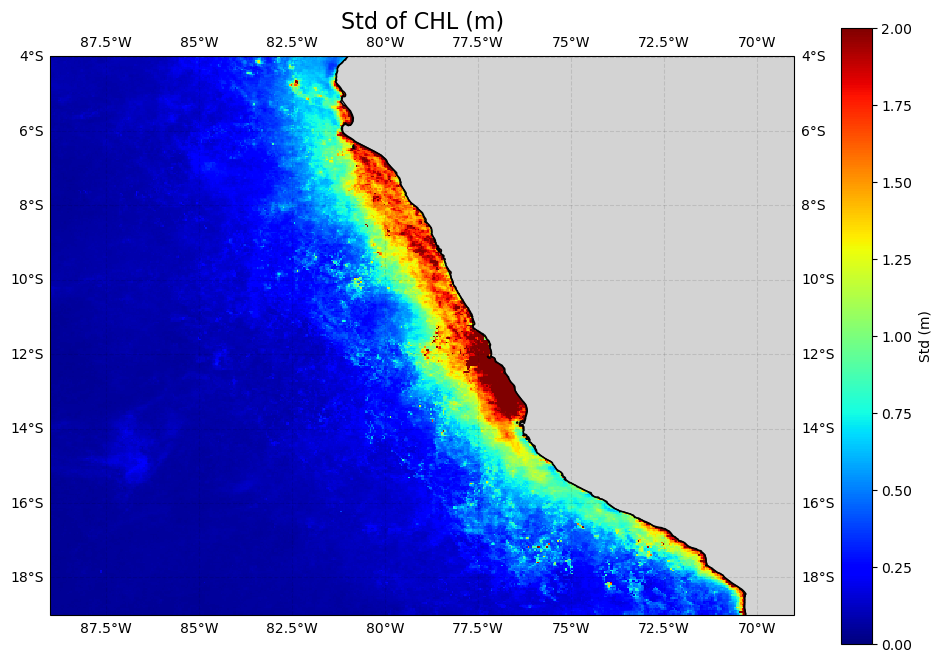

In [468]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m'),
               facecolor='lightgray', edgecolor='black')
ax.coastlines(resolution='50m', color='black')  # '50m' for moderate resolution
cax2 = ax.pcolormesh(chl_lons, chl_lats, chl_std, vmin=0, vmax=2,
                        cmap='jet',
                        transform=ccrs.PlateCarree())
gl0 = ax.gridlines(draw_labels=True, color='black', alpha=0.1, linestyle='--')
cbar = plt.colorbar(cax2, ax=ax, orientation='vertical', pad=0.05, label='Std (m)')
plt.title('Std of CHL (m)', fontsize=16)
plt.show()

**Задание 3**. Сопоставьте данные по SST и SLA c данными новой альтиметрической миссии SWOT (файл **SWOT.nc**) для районе течения Гольфстрим. 

SST - файл **SLA_gulfstream.nc**

SLA - файл **SST_gulfstream.nc**

In [469]:
#load data SWOT
ds = nc.Dataset('/Users/user/Yandex.Disk.localized/Лекции/ПУ/Школа/День_1/Альтиметрия/Задание 2/SWOT.nc','r')
latitude = ds.variables['latitude'][:]
longitude = ds.variables['longitude'][:]
ssh = ds.variables['ssha_filtered'][:]

In [470]:
#load data SST
st_ost = nc.Dataset('/Users/user/Yandex.Disk.localized/Лекции/ПУ/Школа/День_1/Альтиметрия/Задание 2/SST_gulfstream.nc','r')
ost_lons = st_ost.variables['longitude'][:]
ost_lats = st_ost.variables['latitude'][:]
ost = st_ost.variables['analysed_sst'][:]
ost = ost.squeeze()
ost = ost-273.15

In [471]:
#load data SLA
sla_ost = nc.Dataset('/Users/user/Yandex.Disk.localized/Лекции/ПУ/Школа/День_1/Альтиметрия/Задание 2/SLA_gulfstream.nc','r')
sla_ost.variables.keys()
sla_lons = sla_ost.variables['longitude'][:]
sla_lats = sla_ost.variables['latitude'][:]
sla = sla_ost.variables['sla'][:]
sla = sla.squeeze()

Визулизируйте трек SWOT (постройте трек прохождения спутника)

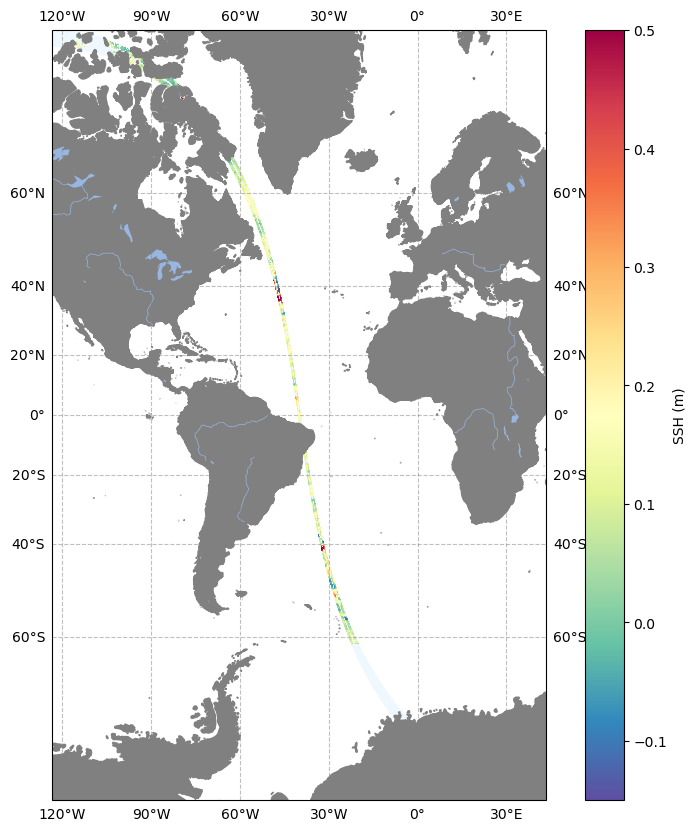

In [472]:
#Визулизируйте трек SWOT (постройте трек прохождения спутника)

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Mercator()))
land = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='gray')
ax.add_feature(land)
ax.add_feature(cfeature.RIVERS, linewidth=0.5)
ax.add_feature(cfeature.LAKES, linewidth=0.5)

latitude = ds.variables['latitude'][:]
longitude = ds.variables['longitude'][:]
ssh = ds.variables['ssha_filtered'][:]

masked_array = np.ma.array (ssh, mask=np.isnan(ssh))
cmap = plt.cm.Spectral_r
cmap.set_bad('aliceblue',1.)
cax = ax.pcolormesh(longitude, latitude, ssh, vmin=-0.15, 
                    vmax=0.5, cmap=cmap, transform=ccrs.PlateCarree())
    
cbar = plt.colorbar(cax, label='SSH (m)')
gl0 = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
plt. show()

Постройте распределение данных SWOT. Настройте лимиты географического домена: 44-49N, 46-51W

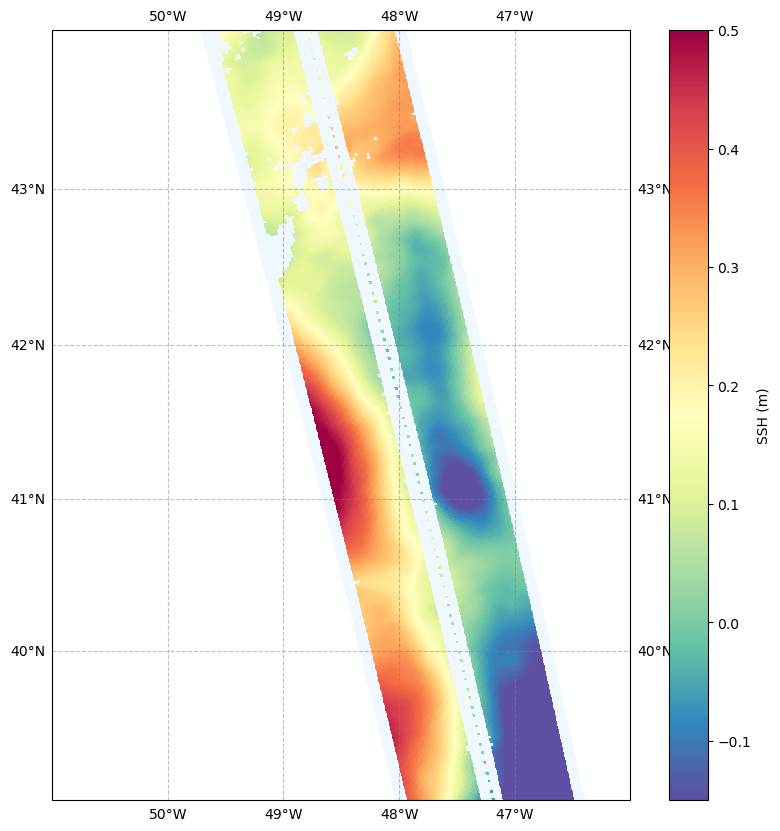

In [473]:
#set map limits: 
limits = [-51,-46,44,39]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Mercator()))
land = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='gray')
ax.add_feature(land)
ax.add_feature(cfeature.RIVERS, linewidth=0.5)
ax.add_feature(cfeature.LAKES, linewidth=0.5)

latitude = ds.variables['latitude'][:]
longitude = ds.variables['longitude'][:]
ssh = ds.variables['ssha_filtered'][:]

masked_array = np.ma.array (ssh, mask=np.isnan(ssh))
cmap = plt.cm.Spectral_r
cmap.set_bad('aliceblue',1.)
cax = ax.pcolormesh(longitude, latitude, ssh, vmin=-0.15, 
                    vmax=0.5, cmap=cmap, transform=ccrs.PlateCarree())
    
cbar = plt.colorbar(cax, label='SSH (m)')
ax.set_extent(limits, crs=ccrs.PlateCarree())
gl0 = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
plt. show() 

Постройте распределение данных SST.

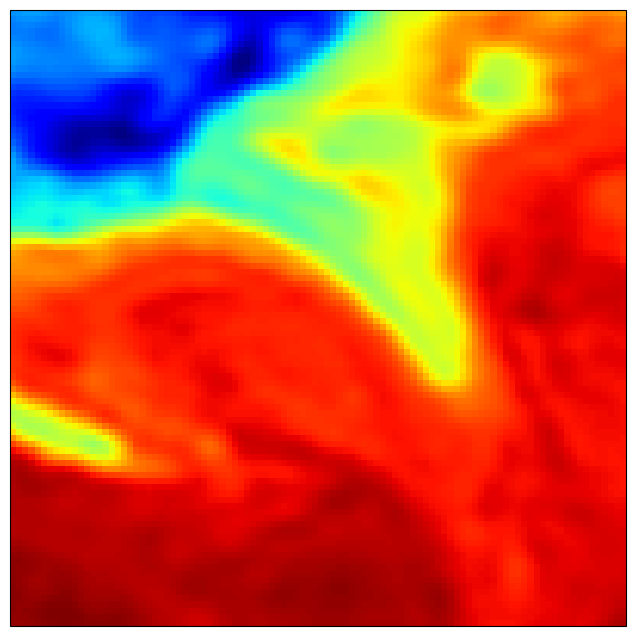

In [474]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m'),
               facecolor='lightgray', edgecolor='black')
ax.coastlines(resolution='50m', color='black')  # '50m' for moderate resolution
cax1 = ax.pcolormesh(ost_lons, ost_lats, ost,
                        cmap='jet',
                        transform=ccrs.PlateCarree())

Постройте распределение данных SLA

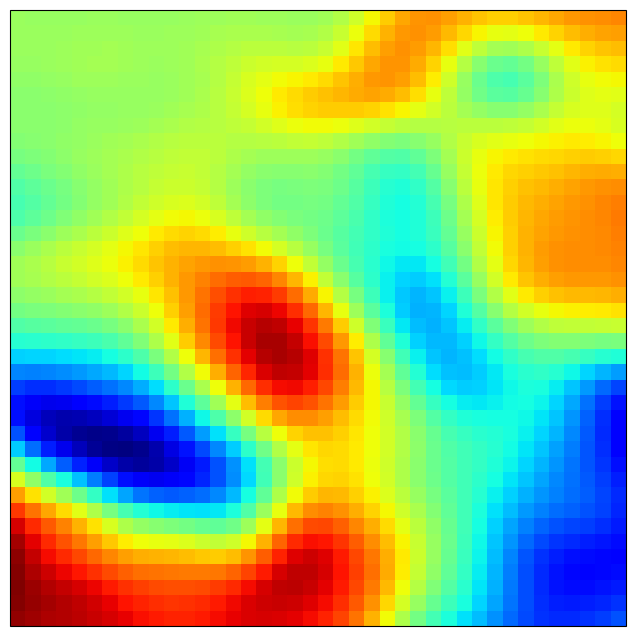

In [475]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m'),
               facecolor='lightgray', edgecolor='black')
ax.coastlines(resolution='50m', color='black')  # '50m' for moderate resolution
cax1 = ax.pcolormesh(sla_lons, sla_lats, sla,
                        cmap='jet',
                        transform=ccrs.PlateCarree())

Наложите поле SWOT на данные SST

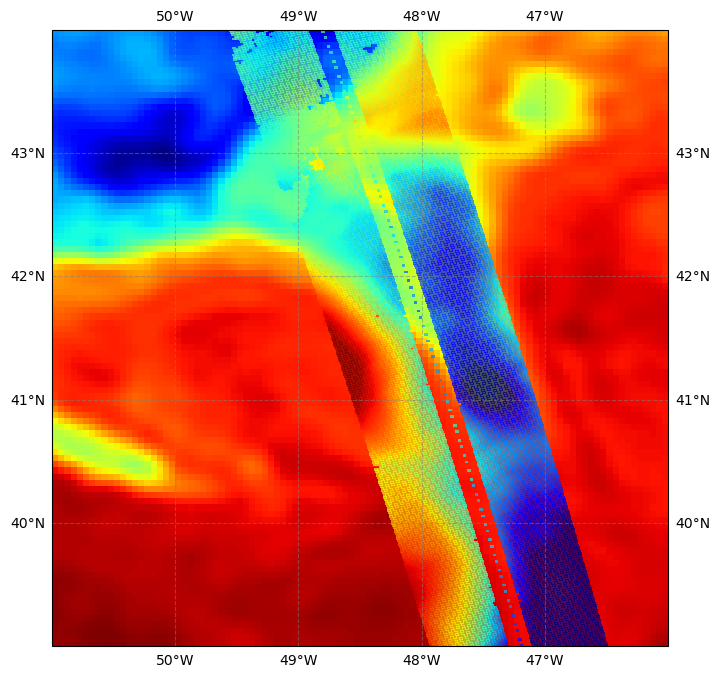

In [476]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m'),
               facecolor='lightgray', edgecolor='black')
ax.coastlines(resolution='50m', color='black')  # '50m' for moderate resolution
cax1 = ax.pcolormesh(ost_lons, ost_lats, ost,
                        cmap='jet',
                        transform=ccrs.PlateCarree())

cax2 = ax.pcolormesh(longitude, latitude, ssh, vmin=-0.15, vmax=0.5, cmap='jet', 
                      transform=ccrs.PlateCarree(), alpha=0.7)  # alpha для прозрачности

ax.set_extent(limits, crs=ccrs.PlateCarree())
gl0 = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
plt. show() 

Наложите поле SWOT на данные SLA

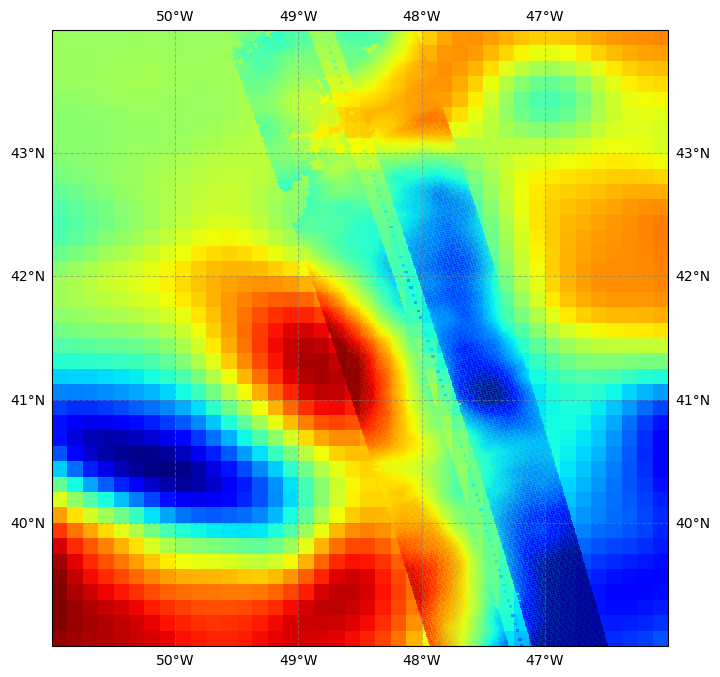

In [477]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m'),
               facecolor='lightgray', edgecolor='black')
ax.coastlines(resolution='50m', color='black')  # '50m' for moderate resolution
cax1 = ax.pcolormesh(sla_lons, sla_lats, sla,
                        cmap='jet',
                        transform=ccrs.PlateCarree())

cax2 = ax.pcolormesh(longitude, latitude, ssh, vmin=-0.2, vmax=0.5, cmap='jet', 
                      transform=ccrs.PlateCarree(), alpha=0.7)  # alpha для прозрачности

ax.set_extent(limits, crs=ccrs.PlateCarree())
gl0 = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
plt. show() 


Проанализируйте сравнение данных. Какие новые структуры в поле аномалий уровня и поле температуры выявляют данные SWOT?  